# MonaLIA Joconde Extended Query

Query Joconde KB augmented by classification scores

In [1]:
from __future__ import print_function

import os
import sys

#import numpy as np
import pandas as pd

import SPARQLWrapper

from  textwrap import wrap

import ipywidgets as widgets

from IPython.display import display, HTML

In [2]:
# Import MonaLIA library from the package in the subfolder of the notebook folder
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import importlib 
from MonaLIA.util import metadata_helpers as metadata
from MonaLIA.util import visualization_helpers as vis_helpers

importlib.reload(metadata)
importlib.reload(vis_helpers)

<module 'MonaLIA.util.visualization_helpers' from 'C:\\Users\\abobashe\\Documents\\MonaLIA\\MonaLIA\\util\\visualization_helpers.py'>

In [3]:
print('SPARQLWrapper ver.', SPARQLWrapper.__version__)

SPARQLWrapper ver. 1.8.5


In [4]:
images_root = 'C:/Joconde/joconde'
output_path = './Classification Illustrations'
wds = "http://localhost:3030/Joconde_plus/query"

In [5]:
def gather_row_annotation(row):
    return '\n'.join( wrap(row.repr, 30 ) +
                    ['',
                     row.ref,
                     '',
                     row.imagePath ])
def abs_image_path(row):
    return os.path.normpath(os.path.join(images_root, row.imagePath.strip('/\\')))

    
formatters_dict={'imagePath': vis_helpers.image_formatter,
                 'info': vis_helpers.label_formatter, 
                 'repr': vis_helpers.repr_formatter,
                 'labels': vis_helpers.label_formatter}


## Search options

In [6]:
query_classifiers = '''
prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
prefix ml: <http://ns.inria.fr/monalia/>
prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>

select *
where {

   ?classifierType ml:vocabID "REPR" .
  
   #?c rdfs:label "Ten classes" .
   ?classifier rdfs:subClassOf ?classifierType.# ml:classifierRepresentedSubject.
   ?classifier rdfs:label ?classifierName.
}
'''

classifiers = metadata.sparql_service_to_dataframe(wds, query_classifiers)
cl_dd = widgets.Dropdown(options= classifiers.classifierName,
                         description='Classifier:')
cl_dd

Dropdown(description='Classifier:', options=('20_classes', 'Twenty_classes', '20_classes_2000', '40_classes'),…

In [7]:
query_categories = '''
prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
prefix ml: <http://ns.inria.fr/monalia/>
prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix skos: <http://www.w3.org/2004/02/skos/core#> 

select *
where {

   ?classifierType ml:vocabID "REPR" .

   #?c rdfs:label "Ten classes" .
   ?classifier rdfs:subClassOf ?classifierType.# ml:classifierRepresentedSubject.
   ?classifier rdfs:label "%s".
  
   ?classifier ml:conatainsClass [ a ?class ; skos:prefLabel ?className].
}
order by ?className
''' % (cl_dd.value)

#print(query_categories)

categories = metadata.sparql_service_to_dataframe(wds, query_categories)
categories.drop_duplicates(inplace=True) #TODO: eventually unnesessary 

In [8]:
cat_dd = widgets.Dropdown(options= categories.className,
                         description='Categories:')

score_fs = widgets.FloatSlider(value=0.9,
                                min=0.0,
                                max=1.0,
                                step=0.1,
                                description='Limit by score:',
                                disabled=False,
                                continuous_update=False,
                                orientation='horizontal',
                                readout=True,
                                readout_format='.1f')

limit_it = widgets.BoundedIntText(value=50,
                                    min=5,
                                    max=1000,
                                    step=1,
                                    description='Limit:',
                                    disabled=False
)
display ( cat_dd, score_fs, limit_it)


Dropdown(description='Categories:', options=('ange', 'arbre', 'armure', 'bateau', 'bateau à voiles', 'casque',…

FloatSlider(value=0.9, continuous_update=False, description='Limit by score:', max=1.0, readout_format='.1f')

BoundedIntText(value=50, description='Limit:', max=1000, min=5)

## Search for a category without scores

In [16]:
query_without_scores = '''

#MonaLIA Search by Score.rq
prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
prefix skos: <http://www.w3.org/2004/02/skos/core#> 
prefix jcl: <http://jocondelab.iri-research.org/ns/jocondelab/>
prefix dc: <http://purl.org/dc/elements/1.1/> 
prefix rdf:   <http://www.w3.org/1999/02/22-rdf-syntax-ns#> 
prefix ml: <http://ns.inria.fr/monalia/>

select     (sample(?noticeRef) as ?ref)
           (sample(?noticeTitr) as ?title)
           (sample(?noticeRepr) as ?repr)
           (sample(?noticeImagePath) as ?imagePath)
           (group_concat(distinct ?subCategory_label;separator="+") as ?labels)
           
where {

    VALUES (?searchCategory_label) { ("%s"@fr) }
 
    ?searchCategory a jcl:Term.
    ?searchCategory skos:prefLabel ?searchCategory_label.
 
  #?notice jcl:noticeRef "5002C002115".
  ?notice jcl:noticeRef  ?noticeRef.
  ?notice jcl:noticeImage [ jcl:noticeImageIsMain true ; jcl:noticeImagePath ?noticeImagePath].
  optional{?notice jcl:noticeTitr  ?noticeTitr.}
  optional{?notice jcl:noticeRepr  ?noticeRepr.}
  optional{?notice ml:noticeImage [  ml:imageWidth ?width]. }
  
  #?notice jcl:noticeReprTerm ?searchCategory
  
  ?notice jcl:noticeReprTerm ?subCategory.
  ?subCategory skos:broader* ?searchCategory.
  ?subCategory  skos:prefLabel ?subCategory_label.
  
  filter (?width > 0)
}
group by ?notice
limit %d
''' % (cat_dd.value,  limit_it.value)

In [17]:
search_results_orig = metadata.sparql_service_to_dataframe(wds, query_without_scores)
search_results_orig.shape

(5, 5)

In [18]:
search_results_orig['imagePath'] = search_results_orig.apply(abs_image_path, axis=1)
search_results_orig['info'] = search_results_orig.apply(gather_row_annotation, axis=1)

imagePath,info,labels
,"représentation animalière(chevreuil, chien, agressionanimale, chasse à courre) ;feuillu000PE032540C:\Joconde\joconde\0365\m072904_82-001403_p.jpg",chien
,"paysage (auberge, enseigne,chaumière, cheval, chien,charrette, puits) ; chemin(voyageur)000PE017654C:\Joconde\joconde\0368\m062904_02-003286_p.jpg",chien
,"scène (allégorie : gloire,femme, aile, torche, nudité,draperie, nuée, putti, effetde lumière, allégorie : vice,homme, nudité, fuite, chute,effet de tissu) ; voûte (décord'architecture) ; scène (?, enmédaillon, homme, femme,garçon, nu) ; figure(allégorie : ?, femme, assis,nudité, draperie, couronne :fleur, putti, chien, effet delumière) ; figure (satyre,assis, couronne, vigne, putti,fourrure, flèche)00000094564C:\Joconde\joconde\0001\m021104_rimg0093_p.jpg",chien
,"autoportrait (Breslau Louise,peintre, femme, à mi-corps,manteau, chapeau, chien)00160000481C:\Joconde\joconde\0396\m001600_3t03445_p.jpg",chien
,"scène (homme, de dos,musicien, danse, violon, chien: habillage)00130103802C:\Joconde\joconde\0708\m001302_0064967-1_p.jpg",chien

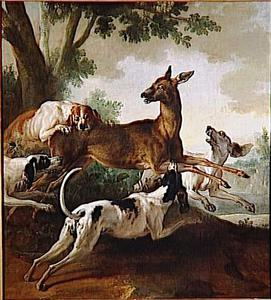
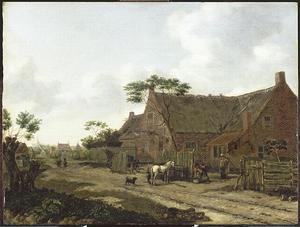
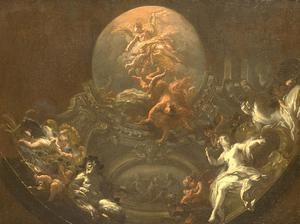
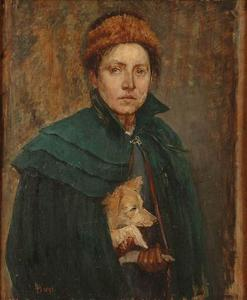
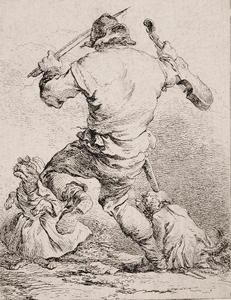

In [19]:
pd.set_option('display.max_colwidth', None)
pd.set_option('colheader_justify', 'center') 

HTML(search_results_orig.loc[:, ['imagePath', 'info', 'labels']].to_html( formatters=formatters_dict, 
                                                                escape=False,
                                                                index=False))

In [162]:
search_results_orig.loc[:, ['imagePath', 'info', 'score']].to_html( os.path.join(output_path, '%s.retrieval without scores.%s.top %d.html' % ( cat_dd.value, cl_dd.value, limit_it.value)),
                                                                formatters=formatters_dict, 
                                                                escape=False,
                                                                index=False)

## Search for a category with scores

In [25]:
query_with_scores = '''

#MonaLIA Search by Score.rq
prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix skos: <http://www.w3.org/2004/02/skos/core#> 
prefix jcl: <http://jocondelab.iri-research.org/ns/jocondelab/>
#prefix dc: <http://purl.org/dc/elements/1.1/> 
prefix ml: <http://ns.inria.fr/monalia/>

select     ?searchCategory_label  
           ?searchScore_value 
           ?ref
           ?title
           ?repr
           ?score
           ?imagePath
where {

    VALUES (?searchCategory_label) { ("%s"@fr) }

    ?searchCategory a jcl:Term.
    ?searchCategory skos:prefLabel ?searchCategory_label.
   
    VALUES (?classifierName) { ("%s")} 
    
    ?classifierType ml:vocabID "REPR" .
    ?classifier rdfs:subClassOf ?classifierType.
    ?classifier rdfs:label ?classifierName.

    VALUES (?searchScore_value) { (%.2f) }
 
    #?notice jcl:noticeRef "00000055013".
    ?notice jcl:noticeRef  ?ref.
    ?notice jcl:noticeTitr  ?title.
    ?notice jcl:noticeRepr  ?repr.
    ?notice jcl:noticeImage [ jcl:noticeImageIsMain true ; jcl:noticeImagePath ?imagePath].
    #?notice jcl:noticeAutr "MENE Pierre Jules".
  
    ?notice ml:imageClassifier ?c.
    #?c a ml:classifierTenClasses.
    ?c a ?classifier.
  
    ?c ml:detected ?l.
    ?l a ?searchCategory .
    ?l ml:score ?score.
  
  
    FILTER ( ?score >= ?searchScore_value )
}
order by desc(?score)
limit %d
''' % (cat_dd.value, cl_dd.value, score_fs.value,  limit_it.value)

In [26]:
print(query_with_scores)



#MonaLIA Search by Score.rq
prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix skos: <http://www.w3.org/2004/02/skos/core#> 
prefix jcl: <http://jocondelab.iri-research.org/ns/jocondelab/>
#prefix dc: <http://purl.org/dc/elements/1.1/> 
prefix ml: <http://ns.inria.fr/monalia/>

select     ?searchCategory_label  
           ?searchScore_value 
           ?ref
           ?title
           ?repr
           ?score
           ?imagePath
where {

    VALUES (?searchCategory_label) { ("chien"@fr) }

    ?searchCategory a jcl:Term.
    ?searchCategory skos:prefLabel ?searchCategory_label.
   
    VALUES (?classifierName) { ("40_classes")} 
    
    ?classifierType ml:vocabID "REPR" .
    ?classifier rdfs:subClassOf ?classifierType.
    ?classifier rdfs:label ?classifierName.

    VALUES (?searchScore_value) { (0.90) }
 
    #?notice jcl:noticeRef "00000055013".
    ?notice jcl:noticeRef  ?ref.
    ?notice jcl:noticeTitr  ?tit

In [27]:
search_results = metadata.sparql_service_to_dataframe(wds, query_with_scores)
search_results.shape

(5, 7)

In [28]:
search_results['imagePath'] = search_results.apply(abs_image_path, axis=1)
search_results['info'] = search_results.apply(gather_row_annotation, axis=1)

C:\Users\abobashe\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


imagePath,info,score
,"représentation animalière(tête d'animal, chien)50130000049C:\Joconde\joconde\0333\m501304_0001456_p.jpg",0.9994
,"représentation animalière(chien, agression animale)00000104611C:\Joconde\joconde\0002\m503604_94de52490_p.jpg",0.9993
,représentation animalière(chien)50130000521C:\Joconde\joconde\0627\m501304_93-004782-01_p.jpg,0.9993
,"scène (homme, chien, chasse àcourre)M5009001759C:\Joconde\joconde\0376\m500904_07-520439_p.jpg",0.9992
,"scène (homme, femme : bergère,galanterie, mouton, chien,cage : oiseau, habillement :18e siècle)01720000056C:\Joconde\joconde\0041\m017204_0000325_p.jpg",0.9991

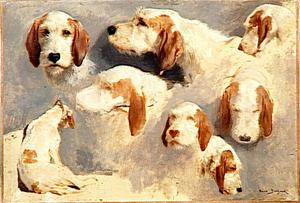
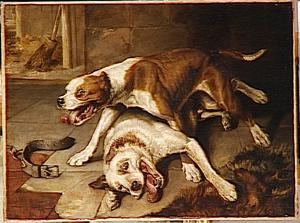
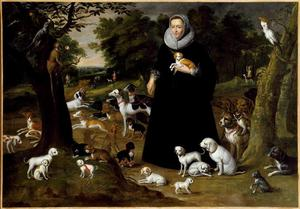
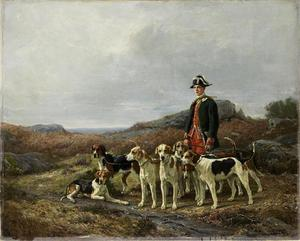
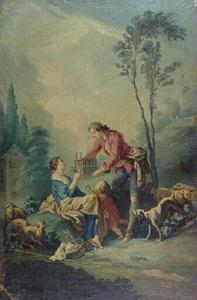

In [29]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('colheader_justify', 'center') 

HTML(search_results.loc[:, ['imagePath', 'info', 'score']].to_html( 
                        formatters=formatters_dict, 
                        escape=False,
                        index=False))

In [161]:
search_results.loc[:, ['imagePath', 'info', 'score']].to_html( os.path.join(output_path, '%s.retrieval.%s.top %d.html' % ( cat_dd.value, cl_dd.value, limit_it.value)),
                                                                formatters=formatters_dict, 
                                                                escape=False,
                                                                index=False)

## Mislabeled (silence) or False Positives 

In [32]:
query_FP = '''
prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix skos: <http://www.w3.org/2004/02/skos/core#> 
prefix jcl: <http://jocondelab.iri-research.org/ns/jocondelab/>
#prefix dc: <http://purl.org/dc/elements/1.1/> 
prefix ml: <http://ns.inria.fr/monalia/>

select  (sample(?searchCategory_label)  as ?searchedFor) #Redundant - delete 
        (sample(?searchScore_value) as ?searchScore) #Redundant - delete 
        (sample(?noticeRef) as ?ref)
        (sample(?noticeTitr) as ?title)
        (sample(?noticeRepr) as ?repr)
        (sample(?pred_score) as ?score)
        (sample(?noticeImagePath) as ?imagePath)
        (group_concat(distinct ?subCategory_label;separator="+") as ?labels)
where {

        VALUES (?searchCategory_label) { ("%s"@fr) }

        ?searchCategory a jcl:Term.
        ?searchCategory skos:prefLabel ?searchCategory_label.
        
        VALUES (?classifierName) { ("%s")} 
    
        ?classifierType ml:vocabID "REPR" .
        ?classifier rdfs:subClassOf ?classifierType.
        ?classifier rdfs:label ?classifierName.

        VALUES (?searchScore_value) { (%.1f) }
  
        #?notice jcl:noticeRef "00000055013". #"00640023488". #"00000055013".
        ?notice jcl:noticeRef  ?noticeRef.
        ?notice jcl:noticeTitr  ?noticeTitr.
        ?notice jcl:noticeRepr  ?noticeRepr.
        ?notice jcl:noticeImage [ jcl:noticeImageIsMain true ; jcl:noticeImagePath ?noticeImagePath].
  
        optional {?notice jcl:noticeReprTerm ?subCategory.
                  ?subCategory skos:broader* ?searchCategory.
                  ?subCategory  skos:prefLabel ?subCategory_label.
                 }
  
        ?notice ml:imageClassifier ?c.
        #?c a ml:classifierTenClasses.
        ?c a ?classifier.
        ?c ml:detected ?l.
        ?l a ?searchCategory.
        ?l ml:score ?pred_score.
        FILTER ( ?pred_score >= ?searchScore_value ) #GENERAL, POSITIVES
        #FILTER ( ?pred_score < ?searchScore_value )  #NEGATIVES
  
  
        FILTER (!BOUND(?subCategory)) # FALSE POSITIVES
        #FILTER (BOUND(?subCategory)) # TRUE POSITIVES, FALSE NEGATIVES
}
group by ?notice
order by desc(?score) 
limit %d
''' %  (cat_dd.value, cl_dd.value, score_fs.value, limit_it.value)

search_results_FP = metadata.sparql_service_to_dataframe(wds, query_FP)

search_results_FP['imagePath'] = search_results_FP.apply(abs_image_path, axis=1)
search_results_FP['info'] = search_results_FP.apply(gather_row_annotation, axis=1)

                Mislabeled (silence) or False Positives


imagePath,info,score
,"scène biblique (Bon Pasteur,brebis) ; fond de paysage(forêt, feuillu, plaine,montagne, volcan, Italie)07480003046C:\Joconde\joconde\0594\m074801_0006136_p.jpg",0.9986
,"scène biblique (Christ, homme,lion, serpent, panthère, loup); fond de paysage05120015061C:\Joconde\joconde\0659\m051202_0006947_p.jpg",0.9984
,"représentation animalière(loup, debout, à droite)M0810000895C:\Joconde\joconde\0424\m081089_001120_p.jpg",0.998
,représentation animalière(lièvre)M0810001825C:\Joconde\joconde\0425\m081089_002077_p.jpg,0.9978
,"scène biblique (Adam, Eve : enpied, pommier, serpent, lion,tigre, éléphant, cheval,girafe, tortue, chèvre,crocodile, hippopotame,baleine, canard, mer, fleur,soleil, étoile, lune, ciel,Dieu le Père)M0537000122C:\Joconde\joconde\0430\m053702_000049_p.jpg",0.9977

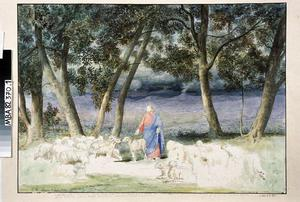
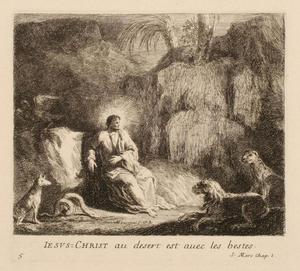
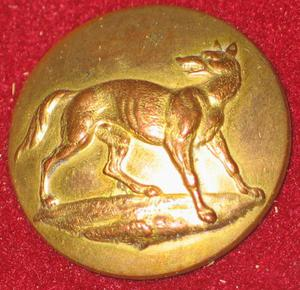
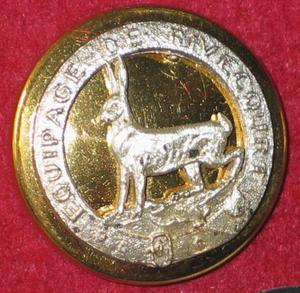
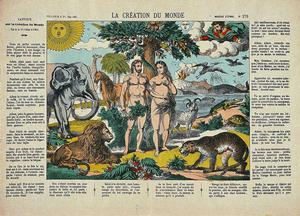

In [33]:
print('                Mislabeled (silence) or False Positives'                   )
HTML(search_results_FP.loc[:, ['imagePath', 'info', 'score']].to_html(formatters=formatters_dict, 
                                                                        escape=False,
                                                                        index=False))

In [175]:
search_results_FP.loc[:, ['imagePath', 'info', 'score']].to_html(  os.path.join(output_path, '%s.silence and false positives.%s.top %d.html' % ( cat_dd.value, cl_dd.value, limit_it.value)),
                                                                    formatters=formatters_dict, 
                                                                    escape=False,
                                                                    index=False)

## Mislabeled (noise) or False Negatives 

In [34]:
query_FN = '''
prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix skos: <http://www.w3.org/2004/02/skos/core#> 
prefix jcl: <http://jocondelab.iri-research.org/ns/jocondelab/>
#prefix dc: <http://purl.org/dc/elements/1.1/> 
prefix ml: <http://ns.inria.fr/monalia/>

select  (sample(?searchCategory_label)  as ?searchedFor) #Redundant - delete 
        (sample(?searchScore_value) as ?searchScore) #Redundant - delete 
        (sample(?noticeRef) as ?ref)
        (sample(?noticeTitr) as ?title)
        (sample(?noticeRepr) as ?repr)
        (sample(?pred_score) as ?score)
        (sample(?noticeImagePath) as ?imagePath)
        (group_concat(distinct ?subCategory_label;separator="+") as ?labels)
where {

    VALUES (?searchCategory_label) { ("%s"@fr) }
 
    ?searchCategory a jcl:Term.
    ?searchCategory skos:prefLabel ?searchCategory_label.
    
    VALUES (?classifierName) { ("%s")} 
    
    ?classifierType ml:vocabID "REPR" .
    ?classifier rdfs:subClassOf ?classifierType.
    ?classifier rdfs:label ?classifierName.
    
    VALUES (?searchScore_value) { (%.1f) }
  
    #?notice jcl:noticeRef "00000055013". #"00640023488". #"00000055013".
    ?notice jcl:noticeRef  ?noticeRef.
    ?notice jcl:noticeTitr  ?noticeTitr.
    ?notice jcl:noticeRepr  ?noticeRepr.
    ?notice jcl:noticeImage [ jcl:noticeImageIsMain true ; jcl:noticeImagePath ?noticeImagePath].
  
    #optional {  
    ?notice jcl:noticeReprTerm ?subCategory.
    ?subCategory skos:broader* ?searchCategory.
    ?subCategory  skos:prefLabel ?subCategory_label.
      #}
  
  ?notice ml:imageClassifier ?c.
  #?c a ml:classifierTenClasses.
  ?c a ?classifier.
  ?c ml:detected ?l.
  ?l a ?searchCategory.
  ?l ml:score ?pred_score.
  #FILTER ( ?pred_score >= ?searchScore_value ) #GENERAL, POSITIVES
  FILTER ( ?pred_score < ?searchScore_value )  #NEGATIVES
  
  
  #FILTER (!BOUND(?subCategory)) # FALSE POSITIVES
  #FILTER (BOUND(?subCategory)) # TRUE POSITIVES, FALSE NEGATIVES
}
group by ?notice
order by ?score 
limit %d
''' %  (cat_dd.value,
        cl_dd.value,
        1-score_fs.value,
        limit_it.value)

search_results_FN = metadata.sparql_service_to_dataframe(wds, query_FN)

search_results_FN.imagePath = search_results_FN.imagePath.apply(lambda x: os.path.join(images_root, x.strip('/\\')))
search_results_FN['info'] = search_results_FN.apply(gather_row_annotation, axis=1)

                 Mislabeled (noise) or False Negatives


imagePath,info,score,labels
,"représentation animalière(silhouette, chien)50440003102C:/Joconde/joconde\0512/m504401_d-6086_p.jpg",0.0331,chien
,"figure (allégorie, ville,femme, debout, robe, draperie,animal, chien, ?)06070005297C:/Joconde/joconde\0454/m060701_0005567_p.jpg",0.0344,chien
,"portrait (Bourbon Charles de,Vendôme duc de, homme, enmédaillon, en buste, armure,attribut, draperie, chêne,branche, couronne, casque,chien)M0277002295C:/Joconde/joconde\0596/m027702_002982_p.jpg",0.0404,chien
,"figure (en médaillon, saintRoch de Montpellier : enbuste, rayons lumineux, croix,gourde, coquille Saint-Jacques, chien) ;ornementation (en encadrement,Trinité : Dieu le Père,balance, Christ, La Croix,colombe : Saint-Esprit, rayonslumineux, rose, phylactère,fleur orn)M0537001207C:/Joconde/joconde\0661/m053702_001098_p.jpg",0.0528,chien
,"nature morte (gibier à plume,objet : chasse aux engins,épagneul)000PE023123C:/Joconde/joconde\0374/m006504_009-004_p.jpg",0.0721,épagneul

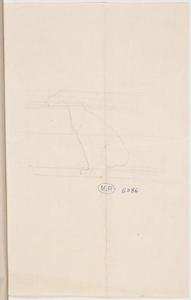
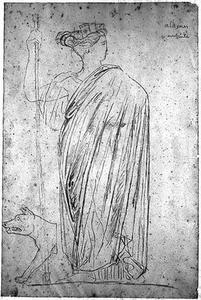
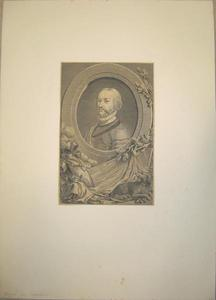
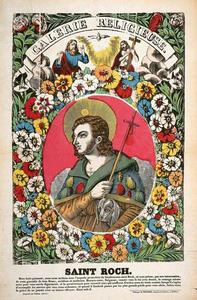
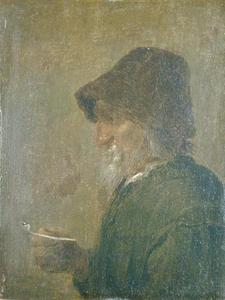

In [35]:
print('                 Mislabeled (noise) or False Negatives')

HTML(search_results_FN.loc[:, ['imagePath', 'info', 'score', 'labels']].to_html( 
                        formatters=formatters_dict, 
                        escape=False,
                        index=False))

In [123]:
search_results_FN.loc[:, ['imagePath', 'info', 'score']].to_html(  os.path.join(output_path,  '%s.noise and false negatives.%s.top %d.html' % ( cat_dd.value, cl_dd.value, limit_it.value)),
                                                                    formatters=formatters_dict, 
                                                                    escape=False,
                                                                    index=False)

## Compare scores of different classifiers

In [36]:
cl1_dd = widgets.Dropdown(options= classifiers.classifierName,
                         description='Classifier 1:')

cl2_dd = widgets.Dropdown(options= classifiers.classifierName,
                         description='Classifier 2:')

display(cl1_dd, cl2_dd)

Dropdown(description='Classifier 1:', options=('20_classes', 'Twenty_classes', '20_classes_2000', '40_classes'…

Dropdown(description='Classifier 2:', options=('20_classes', 'Twenty_classes', '20_classes_2000', '40_classes'…

In [37]:
query_categories_templ = '''
prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
prefix ml: <http://ns.inria.fr/monalia/>
prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix skos: <http://www.w3.org/2004/02/skos/core#> 

select *
where {

   ?classifierType ml:vocabID "REPR" .

   #?c rdfs:label "Ten classes" .
   ?classifier rdfs:subClassOf ?classifierType.# ml:classifierRepresentedSubject.
   ?classifier rdfs:label "%s".
  
   ?classifier ml:conatainsClass [ a ?class ; skos:prefLabel ?className].
}
order by ?className
''' 

#print(query_categories)

cat1 = metadata.sparql_service_to_dataframe(wds, query_categories_templ % cl1_dd.value)
cat2 = metadata.sparql_service_to_dataframe(wds, query_categories_templ % cl2_dd.value)


cat_inter_dd = widgets.Dropdown(options= sorted(set(cat1.className).intersection(cat2.className)),
                         description='Categories:')


limit1_it = widgets.BoundedIntText(value=50,
                                    min=5,
                                    max=1000,
                                    step=1,
                                    description='Limit:',
                                    disabled=False)

display(cat_inter_dd,  limit1_it)

Dropdown(description='Categories:', options=('ange', 'arbre', 'bateau', 'chapeau', 'cheval', 'chien', 'château…

BoundedIntText(value=50, description='Limit:', max=1000, min=5)

In [38]:
query_compare = '''

PREFIX aml: <https://w3id.org/i40/aml#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
#MonaLIA Search by Score.rq
prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
prefix skos: <http://www.w3.org/2004/02/skos/core#> 
prefix jcl: <http://jocondelab.iri-research.org/ns/jocondelab/>
prefix dc: <http://purl.org/dc/elements/1.1/> 
prefix rdf:   <http://www.w3.org/1999/02/22-rdf-syntax-ns#> 
prefix ml: <http://ns.inria.fr/monalia/>

select ?searchCategory_label  
           ?searchScore_value 
           ?ref
           ?title
           ?repr
           ?score1
           ?score2
           ((?score1-?score2) as ?diff)
           ?imagePath
where {

    VALUES (?searchCategory_label) { ("%s"@fr) }
 
    ?searchCategory a jcl:Term.
    ?searchCategory skos:prefLabel ?searchCategory_label.
   
    ?classifierType ml:vocabID "REPR" .
    
    ?classifier1 rdfs:subClassOf ?classifierType.
    ?classifier1 rdfs:label "%s".
    
    ?classifier2 rdfs:subClassOf ?classifierType.
    ?classifier2 rdfs:label "%s".

    #VALUES (?searchScore_value) { (0.9) }
    
 
    #?notice jcl:noticeRef "50030003882".
    ?notice jcl:noticeRef  ?ref.
    ?notice jcl:noticeImage [ jcl:noticeImageIsMain true ; jcl:noticeImagePath ?imagePath].
    optional {?notice jcl:noticeTitr  ?title.}
    optional {?notice jcl:noticeRepr  ?repr.}
  
    
    ?notice ml:imageClassifier ?c1.
  
    ?c1 a ?classifier1.
    ?c1 ml:detected ?l1.
    ?l1 a ?searchCategory .
    ?l1 ml:score ?score1.
  
    ?notice ml:imageClassifier ?c2.
    
    ?c2 a ?classifier2.    
    ?c2 ml:detected ?l2.
    ?l2 a ?searchCategory .
    ?l2 ml:score ?score2.
  
    #FILTER ( ?score1 >= ?searchScore_value )
}

order by desc(?diff)
limit %d
''' % (cat_inter_dd.value, cl1_dd.value, cl2_dd.value,  limit1_it.value)

In [39]:
print(query_compare)



PREFIX aml: <https://w3id.org/i40/aml#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
#MonaLIA Search by Score.rq
prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
prefix skos: <http://www.w3.org/2004/02/skos/core#> 
prefix jcl: <http://jocondelab.iri-research.org/ns/jocondelab/>
prefix dc: <http://purl.org/dc/elements/1.1/> 
prefix rdf:   <http://www.w3.org/1999/02/22-rdf-syntax-ns#> 
prefix ml: <http://ns.inria.fr/monalia/>

select ?searchCategory_label  
           ?searchScore_value 
           ?ref
           ?title
           ?repr
           ?score1
           ?score2
           ((?score1-?score2) as ?diff)
           ?imagePath
where {

    VALUES (?searchCategory_label) { ("chien"@fr) }
 
    ?searchCategory a jcl:Term.
    ?searchCategory skos:prefLabel ?searchCategory_label.
   
    ?classifierType ml:vocabID "REPR" .
    
    ?classifier1 rdfs:subClassOf ?classifierType.
    ?classifier1 rdfs:label "20_classes".
    
    ?classifier2 rdfs:subClassOf ?classi

In [40]:
search_results_comp = metadata.sparql_service_to_dataframe(wds, query_compare)

In [41]:
search_results_comp.imagePath = search_results_comp.imagePath.apply(lambda x: os.path.join(images_root, x.strip('/\\')))
search_results_comp.repr.fillna(value='', inplace=True)
search_results_comp['info'] = search_results_comp.apply(gather_row_annotation, axis=1)

                 Compare classifiers: score1 = 20_classes , score2=40_classes


imagePath,info,score1,score2,diff
,main50410005071C:/Joconde/joconde\0012/m504101_96cn2001#1_p.jpg,0.9903,0.0338,0.9565
,"groupes de figures (soldat,cantinière, trompette)5002E012682C:/Joconde/joconde\0653/m500202_08-521090_p.jpg",0.955,0.0294,0.9256
,"scène (satirique, singe,fumeur, pipe)000PE020116C:/Joconde/joconde\0032/m006504_0005336_p.jpg",0.9929,0.0688,0.92410004
,main (expression du corps)50350014692C:/Joconde/joconde\0280/m503501_d0014692-000_p.jpg,0.9229,0.0066,0.9163
,"représentation animalière(chien, tête)M0794018463C:/Joconde/joconde\0434/m079406_013078_p.jpg",0.9718,0.0647,0.9071

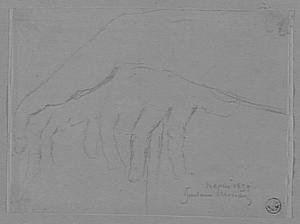
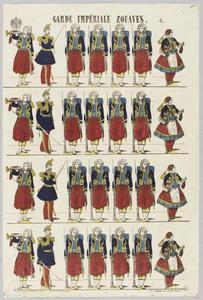
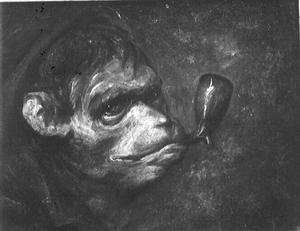
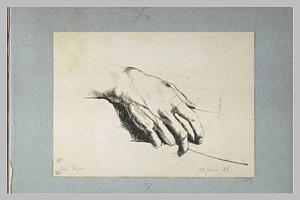
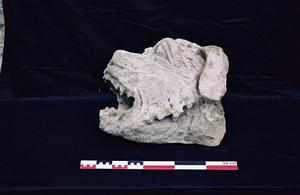

In [42]:
print('                 Compare classifiers: score1 = %s , score2=%s' % (cl1_dd.value, cl2_dd.value))

HTML(search_results_comp.loc[:, ['imagePath', 'info', 'score1', 'score2', 'diff']].to_html( 
                        formatters=formatters_dict, 
                        escape=False,
                        index=False))